# Applied Economic Analysis: Python Assignment <a id='begin'></a>

|Name|ANR|
|----|-------|
|Joost Bouten|132978|
|Twan Vissers|495770|

![image](https://criptonetwork.com/wp-content/uploads/2017/05/coins1.png)

# Exploring the world of cryptocurrencies

This page is for educational purposes and should not be mistaken for investment advice.
The python code and data used here can be found at [github](https://github.com/joostbouten/assignments/tree/master/Final%20Assignment%20).

## Questions

- Out of the ten most valuable cryptocurrencies, which would be the best investment according to the [Sharpe ratio](https://web.stanford.edu/~wfsharpe/art/sr/sr.htm)? 
- Within the market for cryptocurrencies, what is the relation between average returns and volatility of prices?
- What would a machine learning algorithm predict for the price of a cryptocurrency, given that it only bases its prediction on historical price data? 

### Motivation

Cryptocurrencies are a hot topic. Since the hype around Bitcoin started, many entrepreneurs have taken a shot at developing their own coin or other product based on the blockchain technology. 

Being somewhat skeptical about the underlying value of cryptocurrencies, we aim to demonstrate effect of the incredible volatility that this market faces. By analyzing historical price data we hope to gain further insight in this market, as it still seems fuzzy to many people. 

### Method

1. We will start of by importing the data, and performing some graphical as well as numerical exploratory data analysis. 
2. Secondly, we will go on to some investment analysis, where we try to distinguish the best investment pick out of the three most valueable cryptocurrencies using the Sharpe ratio as our metric and the S&P 500 as our benchmark. 
3. Thirdly, we like to get insight into the relation between volatility and return within the cryptocurrency market by plotting a regression line through datapoints for hundreds of cryptocurrencies. We will try to provide further insight into these datapoints by making an interactive plot using the Bokeh package. 
4. Lastly, we will naively try to estimate future cryptocurrency prices using historical price data as an input to a machine learning algorithm. We will construct a function where the symbol of a cryptocurrency along with a given number of days can be used as an input to plot the prediction of the algorithm next to the historical pricing data.

### Answer

- According to the Sharpe ratio, the best pick out of the top three cryptocurrencies seems to be Ethereum. This result can be found [here](#sharpe).
- The relation between average returns and volatility is positive, this can clearly be concluded from the [graph](#regression).
- We find that the prediction that is made by the algorithm may be as good as random. However, we do find some interesting results and the graphs give us some clear insights into the volatility of the blockchain currency market. For example, see [here](#ripple) what happens when we predict Ripple prices 25 days into the future. 

## Assumptions and limitations

Our benchmark for calculating the Sharpe ratio allows us only to compare against closing prices in normal weekdays, therefor we have decided to drop price data for days in which the US stock markets are closed for the sake of simplicity.

We evaluate the investment decision problem using 2017 daily closing rates. These data are likely not at all a good representation of prices in future periods. The market of cryptocurrencies is subject to great debate and speculation as their true value is still very much unclear.

The machine learning algorithm bases its prediction merely on historical price data, it therefore shows results that are very likely not a good representation of reality. 

## Importing libraries and data

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader.data import DataReader 
from datetime import date
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_file, show, output_notebook
from bokeh.models import HoverTool
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

from matplotlib import rcParams, rcParamsDefault

# Hiding annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Setting the plotting style
%matplotlib inline
rcParams['figure.figsize'] = (12.8,4.8)
plt.style.use('seaborn')

# Importing the data
df = pd.read_json("https://api.coinmarketcap.com/v1/ticker/?limit=0")

## Data

The data that we use come from the CoinMarketCap API. 

The data consists of price and circulation data of many cryptocurrencies. We have loaded this data into a dataframe, from which we can nicely display the first few rows of data.

In [2]:
# Data inspection
print('We have',df.shape[0],'rows and',df.shape[1],'columns in this DataFrame')
df.head(5)

We have 1469 rows and 15 columns in this DataFrame


,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,1.170780e+10,1.681539e+07,bitcoin,1.516484e+09,2.179207e+11,2.100000e+07,Bitcoin,0.69,12.69,-10.05,1.000000,12959.600000,1,BTC,1.681539e+07
1,3.936020e+09,9.710569e+07,ethereum,1.516484e+09,1.123960e+11,NaN,Ethereum,0.72,11.78,-17.20,0.090060,1157.460000,2,ETH,9.710569e+07
2,2.369110e+09,3.873914e+10,ripple,1.516484e+09,6.142169e+10,1.000000e+11,Ripple,0.24,2.96,-20.64,0.000123,1.585520,3,XRP,9.999309e+10
3,1.110960e+09,1.692236e+07,bitcoin-cash,1.516484e+09,3.522542e+10,2.100000e+07,Bitcoin Cash,0.28,17.74,-23.46,0.161966,2081.590000,4,BCH,1.692236e+07
4,7.253850e+08,2.592707e+10,cardano,1.516484e+09,1.841535e+10,4.500000e+10,Cardano,0.40,10.85,-17.75,0.000055,0.710275,5,ADA,3.111248e+10


We can see that the data consists of 1469 rows and 15 columns, we do not need much of this data. Let us select some of this data such that we can nicely show some characteristics of the data.

In [3]:
# Selecting the relevant columns
market_cap = df[['name','market_cap_usd']]

# Dropping currencies without market capitalization
market_cap = market_cap.dropna()
market_cap = market_cap.query('market_cap_usd > 0')

# Setting the index
market_cap.set_index('name', inplace=True)

In [4]:
market_cap.head()

,market_cap_usd
name,
Bitcoin,2.179207e+11
Ethereum,1.123960e+11
Ripple,6.142169e+10
Bitcoin Cash,3.522542e+10
Cardano,1.841535e+10


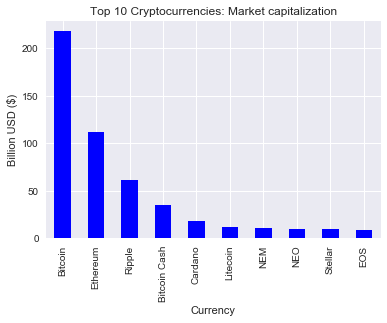

Total market capitalization of cryptocurrencies: $ 633.2 billion


In [5]:
_ = (market_cap[:10]/1000000000).plot.bar(color='blue', legend=False)
_ = plt.title('Top 10 Cryptocurrencies: Market capitalization')
_ = plt.xlabel('Currency')
_ = plt.ylabel('Billion USD ($)')
plt.show()

total_cap = np.sum(market_cap)
print('Total market capitalization of cryptocurrencies: $', round(total_cap[0]/1000000000,2), 'billion')

We can see that the total capitalization of cryptocurrencies is already huge, Bitcoin is the biggest player on the market, followed by Ethereum and Ripple. 

## Some more data

The following dataset is downloaded from [Kaggle](https://www.kaggle.com/jessevent/all-crypto-currencies/data), a platform that hosts data-related competitions. This dataset includes daily price data from 2013 onwards, for all cryptocurrencies. 

In [6]:
# Importing the data
df1 = pd.read_csv('crypto-markets.csv')

# Data inspection
df1.head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [7]:
# Selecting data as of 2017
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.loc[df1['date'] >= '2017']

# Selecting relevant columns
exchange = df1[['symbol','name','close','date']]

# Selecting relevant currencies
exchange.dropna(inplace = True)

exchangeBTC = exchange.loc[exchange['symbol'] == 'BTC'] 
exchangeETH = exchange.loc[exchange['symbol'] == 'ETH'] 
exchangeRIP = exchange.loc[exchange['symbol'] == 'XRP'] 

exchange = pd.concat([exchangeBTC, exchangeETH, exchangeRIP], ignore_index=True)

# Order by date
exchange.sort_values(['date','symbol'], inplace=True)

# Setting the index
exchange.set_index('date', inplace=True)

In [8]:
# Constructing new columns from the closing prices
exchange['Bitcoin'] = exchange.close[0::3]
exchange['Ethereum'] = exchange.close[1::3]
exchange['Ripple'] = exchange.close[2::3]

# Keeping only the relevant columns and dropping duplicate rows
exchange = exchange[['Bitcoin','Ethereum','Ripple']]
exchange = exchange.loc[::3,:]

# Inspecting the dataframe
exchange.head()

,Bitcoin,Ethereum,Ripple
date,,,
2017-01-01,998.33,8.17,0.006368
2017-01-02,1021.75,8.38,0.006311
2017-01-03,1043.84,9.73,0.006386
2017-01-04,1154.73,11.25,0.006570
2017-01-05,1013.38,10.25,0.006201


For now, we are only interested in daily closing prices of the top three cryptocurrencies from 2017 onwards. We have altered the dataframe such that we have our three currencies as columns, dates as indeces and closing prices as values. Next, we will plot closing prices for these currencies and we will show some summary statistics for these data. 

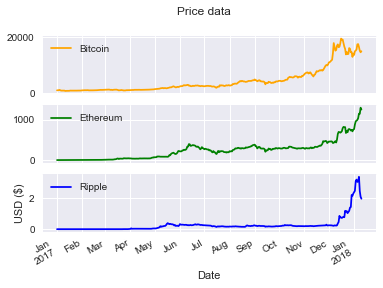

,Bitcoin,Ethereum,Ripple
count,375.000000,375.000000,375.000000
mean,4314.172480,245.937333,0.270975
std,4415.960737,228.729135,0.495798
min,777.760000,8.170000,0.005408
25%,1197.140000,48.260000,0.031331
50%,2608.720000,251.700000,0.197339
75%,4777.005000,317.300000,0.251758
max,19497.400000,1299.740000,3.380000


In [9]:
COLORS = ['orange','green','blue']

_ = exchange.plot.line(title = 'Price data', subplots = True, color=COLORS)
_ = plt.xlabel('Date')
_ = plt.ylabel('USD ($)')
plt.show()

exchange.describe()

As can be seen, Bitcoin prices have always been far ahead, the currencies seem to have become more correlated and Ripple has only begun showing a massive price increase in the recent past. 

As a benchmark we will now load data from the Yahoo Finance API for the S&P 500, we will again select closing prices using the same dates. The S&P 500 is often used as a proxy for the performance of the USA stock market.  

In [10]:
# We will compare these returns against the S&P 500
start = date(2017, 1, 1)
end = date(2018, 1, 10)
ticker = '^GSPC'
data_source = 'yahoo'
stock_data = DataReader(ticker, data_source, start, end)

sp500 = pd.DataFrame(stock_data.Close)

# Data inspection
sp500.head()

RemoteDataError: Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1=1483225200&period2=1515625199&interval=1d&events=history&crumb=5dV%5Cu002FfvGh.9%5Cu002F

In [ ]:
_ = sp500.plot.line(title='S&P 500')
_ = plt.ylabel('USD ($)')
plt.show()

sp500.describe()

As can be seen in the plot above, the S&P 500 has shown some steady progress in 2017 as well. However, while not clearly visible from this graph, the S&P 500 is trumped by cryptocurrencies in terms of performance over 2017. 

Let us now add the S&P 500 data to our cryptocurrency data, and drop all rows in which we have no closing prices for the S&P 500.

In [ ]:
exchange['SP500'] = sp500.Close
exchange.dropna(inplace=True) #to be able to substract SP500 (closed on weekends)
exchange.head()

We can now compute daily returns for all three currencies as well as the S&P 500. Following we can plot daily returns of the cryptocurrencies excess of the S&P 500 returns.

In [ ]:
# Showing the daily risk premium of the three different currencies

daily_returns = exchange.pct_change()
crypto_returns = daily_returns[['Bitcoin','Ethereum','Ripple']]
sp_returns = daily_returns['SP500']
excess_returns = crypto_returns.sub(sp_returns, axis=0)

_ = excess_returns.plot(title = 'Excess returns per currency', color=COLORS)
_.yaxis.set_major_formatter(FuncFormatter(lambda y, _:'{:.0%}'.format(y)))
_ = plt.ylabel('Daily excess returns')
_ = plt.xlabel('Date')
plt.show()


This graph highlights some of the absurd volatility in the cryptocurrency market already. For example, take ripple during the month of may it doubled in value in only a single day. 

Let us calculate the average daily returns, and plot them using a histogram. 

In [ ]:
# The mean of the excess returns
avg_excess_returns = excess_returns.mean()

# Plotting the means of the return differences
_ = avg_excess_returns.plot.bar(title = 'Average risk premium', color=COLORS)
_ = plt.ylabel('Average daily returns')
plt.show()


We can see that Ripple was yielding the highest returns, followed by Ethereum and Bitcoin respectively. It would be logical to believe that returns are positively related to risk, we can check this by plotting the standard deviations.

In [ ]:
# The standard deviation of the excess returns
std_excess_returns = excess_returns.std()

# Plotting the standard devations of the return differences
_ = std_excess_returns.plot.bar(title = 'Volatility of the currencies', color=COLORS)
_ = plt.ylabel('Standard deviation')
plt.show()

While Ripple yielded the highest returns, it also shows to be more risky. Let us now define a function that takes the mean, standard deviation and number of trading days, and returns the annualized Sharpe ratio. 

We define the annualized Sharpe ratio as follows: $\sqrt{n}\cdot\dfrac{\mu_p}{\sigma_p}$, where $n$ is the number of trading days of portfolio $p$, $\mu$ is the average return net of the benchmark rate and $\sigma$ is the standard deviation.

In [ ]:
# We define a function for the annualized Sharpe ratio
def sharpe(mean, std, n_periods):
    return np.sqrt(n_periods)*(mean/std)

# Now we calculate the sharpe ratio for the three cryptocurrencies
pd.DataFrame(sharpe(avg_excess_returns, std_excess_returns, len(excess_returns)),columns=["Annualized Sharpe Ratio"])

## Result <a id='sharpe'></a>
From the table we can read that Ethereum has the greatest annualized Sharpe ratio, followed by Ripple and Bitcoin respectively. Let us nicely print this result.

In [ ]:
print('Based on the Sharpe ratios of these results, it seems best to buy', np.argmax(sharpe(avg_excess_returns, std_excess_returns, len(excess_returns))))

## The relation between return and volatility

From our graphical EDA, we got the idea that average returns and volatility are positively correlated. However, we were not completely convinced and we would like to check this for all cryptocurrencies for which we have data. Let us use the dataset we downloaded from Kaggle, take only closing prices, dates and names. We will use the names as columns, dates as indexes and closing prices as values. 

In [ ]:
rates = df1[['date','name','close']]
rates = rates.pivot_table(index='date',columns='name', values='close', aggfunc='mean') 
rates.head()

By inspection we can see that there are lots of rows for which there is no data for some currencies, this is likely caused by the fact that many currencies came into existence only later in 2017. 

Let us construct a dataframe showing the mean and standard deviation of daily returns for each currency.

In [ ]:
avg_daily_return = rates.pct_change().mean()
std_daily_return = rates.pct_change().std()

avg_daily_return = pd.DataFrame(avg_daily_return).reset_index()
avg_daily_return.columns = ['name', 'avg']

std_daily_return = pd.DataFrame(std_daily_return).reset_index()
std_daily_return.columns = ['-', 'std']

avg_std_dr = pd.concat([avg_daily_return,std_daily_return], axis=1)
avg_std_dr = avg_std_dr[['name','avg','std']]
avg_std_dr.head()

We can plot these data using a scatter plot, but let us firstly color the three top currencies as we did in earlier plots. 

In [ ]:
avg_std_BER = avg_std_dr.loc[(avg_std_dr.name == 'Bitcoin')|(avg_std_dr.name == 'Ethereum')|(avg_std_dr.name == 'Ripple')]
avg_std_BER['colors'] = COLORS
avg_std_BER.head()

We will use an interactive Bokeh plot, this lets the viewer hover over datapoints to show to which currency it belongs. Furthermore, this method is useful as it allows the viewer to zoom and move through the plot, which may be sought after in a scatter plot with so many data points. 

In [ ]:
# Let us make an interactive plot using Bokeh
output_notebook() #comment this part out if you want it to show on another tab
source = ColumnDataSource(avg_std_dr)
p = figure(plot_width=1000 , y_axis_label='Average daily return', x_axis_label='Std. dev. of daily returns', y_range=(-0.05,0.2), x_range=(0,1), title='avg/std relations for each cryptocurrency')
p.circle(y='avg', x='std', source=source, size=5)

source1 = ColumnDataSource(avg_std_BER)
p.inverted_triangle(y='avg', x='std', source=source1, size=15, fill_color='colors', line_color='black')

hover = HoverTool(tooltips=[('Currency','@name')])
p.add_tools(hover)
show(p)

Being economists, we immediately feel the urge to plot a regression line through a scatter plot. Therefore, we will estimate a regression line using numpy's polyfit function, print its slope and intersect, and plot it in our scatter plot. 

<a id='regression'></a>

In [ ]:
# Getting rid of some outliers
avg_std_dr = avg_std_dr[avg_std_dr['avg']<0.5]
avg_std_dr = avg_std_dr[avg_std_dr['std']<4]

# How is the average related to the standard deviation?
_ = plt.plot(avg_std_dr['std'], avg_std_dr['avg'], marker='.', linestyle='none')
_ = plt.ylim(-0.05,0.4)
_ = plt.xlim(0,2)
_ = plt.ylabel('Average daily return')
_ = plt.xlabel('Std. dev. of daily returns')
_ = plt.title('Regression line')

a, b = np.polyfit(avg_std_dr['std'], avg_std_dr['avg'],1)

print('slope = %.5f'% a)
print('intercept = %.5f'% b)

x = np.array([-1,4])
y = a * x + b

_ = plt.plot(x,y)
plt.show()

We can clearly see that there is a positive relation between risk and return in the market for cryptocurrencies. The polyfit estimation gives us an estimated "risk-free" daily return of 0.6%, which clearly is very high. 

## Predicting prices using price history

We will now go on to predict future prices of cryptocurrencies using historical pricing data. As said before, this method may not be highly reliable as future prices may not be based on past prices, but we will do it anyway.

We will start of by using data of a currency, Bitcoin in this case. We will take closing prices and volumes, construct a new column showing the percentage increase of daily maximum prices compared to daily minimum prices, and another column showing closing versus opening price increases. This data is used as features, the machine learning algorithm uses features to predict labels. We will construct a new column called 'label', this column consists of closing prices shifted backward in time with a provided number of days. 

In [ ]:
# Let us try to predict Bitcoin prices
bit = df1[df1.symbol == 'BTC'].drop(['ranknow','close_ratio','slug','symbol','name'], axis=1)
bit['HL_PCT'] = 100*(bit.high - bit.low) / bit.low
bit['CO_PCT'] = 100*(bit.close - bit.open) / bit.open
bit = bit.set_index('date')
bit = bit[['close','HL_PCT','CO_PCT','volume']]

# Chosing 20 days as number of forecast days
forecast_out = int(20)
bit['label'] = bit['close'].shift(-forecast_out)

# We now have 20 days of missing labels 
bit.tail()

Note that due to shifting, the bottom 20 entries of the dataframe have a missing value in the label column. These missing values represent the entries of the label column that we will predict using our algorithm. 

In [ ]:
# We define a matrix of features
X = np.array(bit.drop(['label'], 1))

# Center to the mean and component wise scale to unit variance
X = scale(X)

# Split the rows for which we do not have label data
X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]

# Define label vector
y = np.array(bit['label'])
y = y[:-forecast_out]

# Check whether X and y are equal in lenght (if this is not the case we get an error)
assert(len(X)==len(y))

We have now defined the features and labels. Furthermore we have made sure that there are as many sets of features for which we have label data as there are label data. 

We will estimate how good of a fit we may expect our model to provide by splitting our data into training and test data and checking whether predictions for testing data were in line with their actual values. We will use a linear regression model.

In [ ]:
# We split the data into training and test data
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# We fit the model to the training data and test it on the test data
clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = max(clf.score(X_test, y_test),0)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy is defined as the fraction of correct predictions within the test set. 
The model did reasonably well in predicting the test data, let us now attempt to predict 30 days into the future.   

In [ ]:
forecast_prediction = clf.predict(X_forecast_out)

print(forecast_prediction)

last_date = bit.iloc[-1].name

forecast = pd.DataFrame(forecast_prediction)
forecast['date'] = pd.date_range(last_date + timedelta(days=1) , periods=forecast_out, freq='D')
forecast.set_index(['date'], inplace=True)

forecast['BTC Prediction'] = forecast.loc[:,0]
forecast = forecast[['BTC Prediction']]

# Prevent the plot to have a discontinuity
last_entry = pd.DataFrame(bit.close.iloc[-1], columns=['BTC Prediction'], index=[bit.iloc[-1].name])
forecast = last_entry.append(forecast)

This prediction does not tell us very much without a plot, so let us plot it along the historical data.

In [ ]:
ax = bit['close'].plot(color="green", label='BTC Price')
forecast.plot(color="orange", label='BTC Prediction', ax=ax)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction of Bitcoin')
plt.show()


Note that this model does not know whether Bitcoin is a bubble, it therefore predicts the future only knowing the past prices and not knowing about anything else. The model will therefore predict the prices of Bitcoin to explode in the further future as it did in the past, it is very likely that this is an unrealistic scenario. 

Furthermore, the model allows prices to be negative, this is unrealistic as well.

We have now seen predictions for Bitcoin for 30 days into the future. Naturally, we would like to see predictions for any currency, for any number of days into the future. This can easily be made possible by defining a function. The function uses the same code as the example shown above, it takes two inputs: the symbol of any currency, and the number of days to predict. 

In [ ]:
# Let us define a function which outputs the graph shown above for a given number of future periods
def plot_future(n, coin):
    # Let us try to predict Bitcoin prices
    bit = df1[df1.symbol == coin].drop(['ranknow','close_ratio','slug','symbol','name'], axis=1)
    bit['HL_PCT'] = 100*(bit.high - bit.low) / bit.low
    bit['CO_PCT'] = 100*(bit.close - bit.open) / bit.open
    bit = bit.set_index('date')
    bit = bit[['close','HL_PCT','CO_PCT','volume']]
    
    # Chosing n days as number of forecast days
    forecast_out = int(n)
    bit['label'] = bit['close'].shift(-forecast_out)
    
    # We now have n days of missing labels 
    # We define a matrix of features
    X = np.array(bit.drop(['label'], 1))
    
    # Center to the mean and component wise scale to unit variance
    X = scale(X)
    
    # Split the rows for which we do not have label data
    X_forecast_out = X[-forecast_out:]
    X = X[:-forecast_out]
    
    # Define label vector
    y = np.array(bit['label'])
    y = y[:-forecast_out]
    
    # Check whether X and y are equal in lenght (if this is not the case we get an error)
    assert(len(X)==len(y))
    
    # We split the data into training and test data
    # test_size = 0.2 ==> 20% data is test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    
    # We fit the model to the training data and test it on the test data
    clf = LinearRegression()
    clf.fit(X_train,y_train)
    
    accuracy = max(clf.score(X_test, y_test),0.)
    print("Accuracy of Linear Regression: %.5f"% accuracy)
    forecast_prediction = clf.predict(X_forecast_out)

    last_date = bit.iloc[-1].name
    
    forecast = pd.DataFrame(forecast_prediction)
    forecast['date'] = pd.date_range(last_date + timedelta(days=1) , periods=forecast_out, freq='D')
    forecast.set_index(['date'], inplace=True)
    
    forecast['Prediction'] = forecast.loc[:,0]
    forecast = forecast[['Prediction']]
    
    # Prevent the plot to have a discontinuity
    last_entry = pd.DataFrame(bit.close.iloc[-1], columns=['Prediction'], index=[bit.iloc[-1].name])
    forecast = last_entry.append(forecast)
    
    ax = bit['close'].plot(color="green", label='Price')
    forecast.plot(color="orange", label='Prediction', ax=ax)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Prediction of '+coin)
    plt.show()

Let us use the function to show Bitcoin predictions 200 days into the future.

In [ ]:
# Let us show what the model predicts 200 days into the future
    
plot_future(200, 'BTC')

As can be seen above, the model predicts BTC prices to explode. Let us plot another currency. Note that the title of the graph changes accordingly. 
<a id='ripple'></a>

In [ ]:
plot_future(25,'RPX')

Ripple seems to crash at the end of January... (however, accuracy seems pretty low).
  
<br><br>
  
[Back to the top of the page?](#begin)